# Likelihood curves for multiple sources

In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import sys
import json 
import pandas as pd 
import numpy as np 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [139]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import bilby_priors_dict
import logging 
import numpy as np 
import bilby

In [140]:



h = 1 #doesnt matter
measurement_model = 'pulsar' 
seed = 1237
num_gw_sources = 2 


#Setup the system
P   = SystemParameters(h=h,σp=None,σm=1e-11,use_psr_terms_in_data=True,measurement_model=measurement_model,seed=seed,num_gw_sources=num_gw_sources) # define the system parameters as a dict. Todo: make this a class
PTA = Pulsars(P)                                       # setup the PTA
data = SyntheticData(PTA,P)                            # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1237
INFO:root:Running for two deterministic GW sources
INFO:root:You are assigning the σp terms randomly


INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model


In [146]:

init_parameters_optimal, priors_optimal = bilby_priors_dict(PTA,P,set_parameters_as_known=True)
optimal_parameters = priors_optimal.sample(1)
model_likelihood = KF.likelihood(optimal_parameters)


suboptimal_parameters = optimal_parameters.copy()
suboptimal_parameters['phi0_gw_0'] = np.array(0.20)
suboptimal_parameters['phi0_gw_1'] = np.array(1.45)


new_model_likelihood = KF.likelihood(suboptimal_parameters)

print(new_model_likelihood,model_likelihood,new_model_likelihood-model_likelihood)


INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


586621.5038088122 586621.5036995086 0.0001093036262318492


In [147]:

init_parameters_optimal, priors_optimal = bilby_priors_dict(PTA,P,set_parameters_as_known=True)
optimal_parameters = priors_optimal.sample(1)
model_likelihood = KF.likelihood(optimal_parameters)


suboptimal_parameters = optimal_parameters.copy()
suboptimal_parameters['phi0_gw_0'] = np.array(0.20)
suboptimal_parameters['phi0_gw_1'] = np.array(1.45)


new_model_likelihood = KF.likelihood(suboptimal_parameters)

print(new_model_likelihood,model_likelihood,new_model_likelihood-model_likelihood)


INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


586621.5038088121 586621.5036995086 0.00010930350981652737


Hmmmm, the suboptimal params have a better likelihood than the optimal params. Lets check the other parameter pairs:

# Offset calculations

In [135]:
import matplotlib.pyplot as plt 

def generate_likelihood_surface(xx,yy,parameter):


    likelihood_surface= np.zeros((len(xx), len(yy)))


    for i in range(len(xx)):
        for j in range(len(yy)):
            suboptimal_parameters = optimal_parameters.copy()
            suboptimal_parameters[f'{parameter}_0'] = np.array(xx[i])
            suboptimal_parameters[f'{parameter}_1'] = np.array(yy[j])
            likelihood_surface[i][j] = KF.likelihood(suboptimal_parameters)
            #likelihood_surface[i][j],_,_ = KF.likelihood_with_results(suboptimal_parameters)


    return likelihood_surface





def plot_surface(xx,yy,likelihood_surface,injections):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)



    #Cast to 2D mesh
    X,Y = np.meshgrid(xx,yy)
    lx = len(xx)
    ly = len(yy)
    z = np.reshape(likelihood_surface, (lx, ly))


    #Extract location of maxima
    xx_idx, yy_idx = np.unravel_index(likelihood_surface.argmax(), likelihood_surface.shape)
    xc = xx[xx_idx]
    yc = yy[yy_idx]
    zc = likelihood_surface[xx_idx,yy_idx]

    print("Maxima:", xc,yc,zc)

    eps = 1e-1
    #CS = ax.pcolormesh(X, Y, z,clim=(np.max(likelihood_surface) - eps, np.max(likelihood_surface)),shading='gouraud',cmap='viridis')
    CS = ax.pcolormesh(X, Y, z,clim=(np.min(likelihood_surface), np.max(likelihood_surface)),shading='gouraud',cmap='viridis')

    clb = plt.colorbar(CS)


    ax.scatter(yc,xc)
    ax.scatter(injections[1],injections[0],c='r',marker='x')






Maxima: 0.9500000000000001 0.0 586621.5175682065


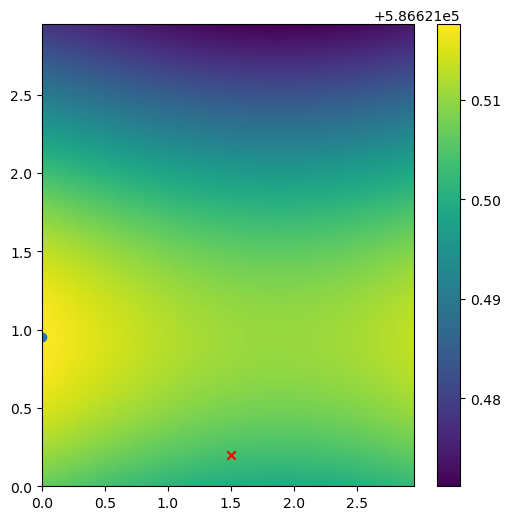

In [136]:
#Phi 0 
xx = np.arange(0,3,0.05)
yy = np.arange(0,3,0.05)

# NN = 40
# xx = np.linspace(0,3,NN)
# yy = np.linspace(0,3,NN)

parameter = 'phi0_gw'
injections = P.Φ0

phi0_ll = generate_likelihood_surface(xx,yy,parameter)

plot_surface(xx,yy,phi0_ll,injections)

In [126]:
phi0_ll.min()

-13744749.121609077

Maxima: 2.5 0.35000000000000003 586621.5036995087


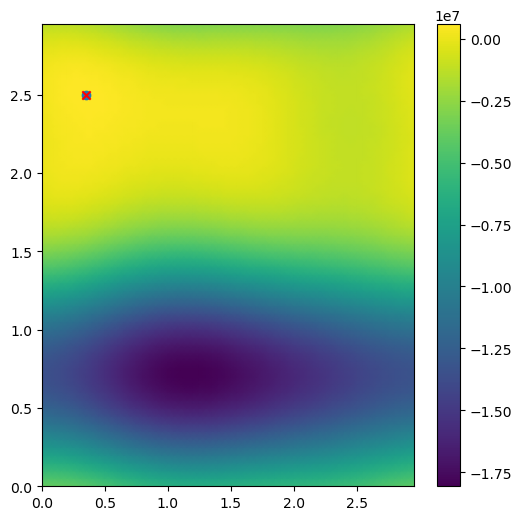

In [127]:
#psi
xx = np.arange(0,3,0.05)
yy = np.arange(0,3,0.05)
parameter = 'psi_gw'
injections = P.ψ

psi_ll = generate_likelihood_surface(xx,yy,parameter)

plot_surface(xx,yy,psi_ll,injections)

Maxima: 2.5 0.35000000000000003 586621.5036995086


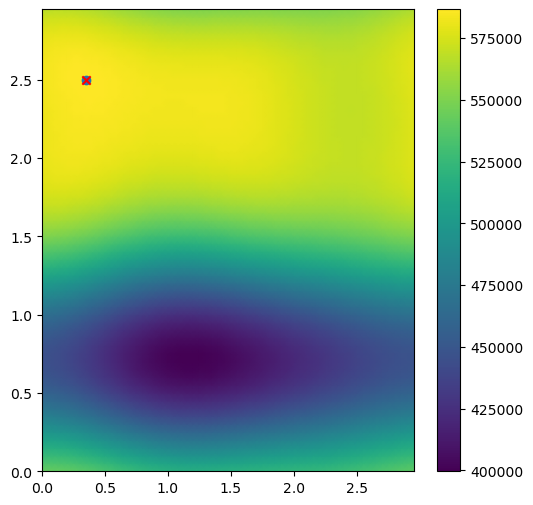

In [110]:
#psi
xx = np.arange(0,3,0.05)
yy = np.arange(0,3,0.05)
parameter = 'psi_gw'
injections = P.ψ

psi_ll = generate_likelihood_surface(xx,yy,parameter)

plot_surface(xx,yy,psi_ll,injections)

Maxima: 1.0 1.0 586621.5036995086


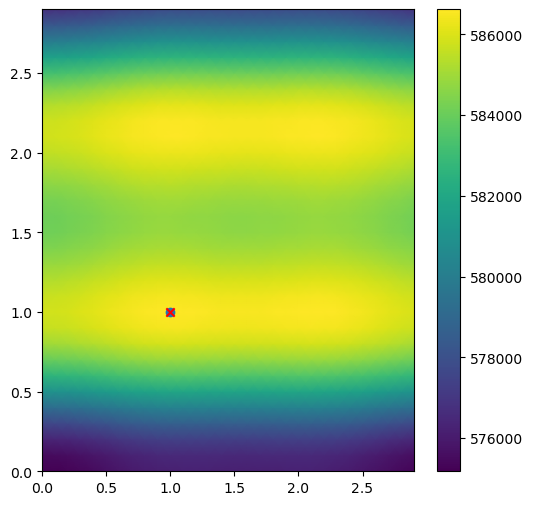

In [111]:
#iota
xx = np.arange(0,3,0.1)
yy = np.arange(0,3,0.1)
parameter = 'iota_gw'
injections = P.ι

iota_ll = generate_likelihood_surface(xx,yy,parameter)

plot_surface(xx,yy,iota_ll,injections)

Maxima: 1.0 0.7000000000000001 586621.5036995086


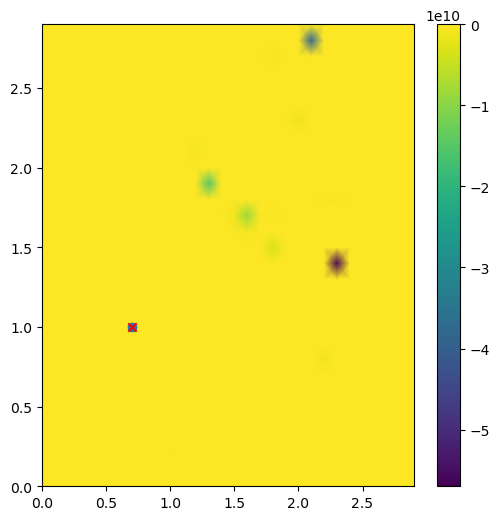

In [112]:
#delta
xx = np.arange(0,3,0.1)
yy = np.arange(0,3,0.1)
parameter = 'delta_gw'
injections = P.δ

delta_ll = generate_likelihood_surface(xx,yy,parameter)

plot_surface(xx,yy,delta_ll,injections)

Maxima: 1.0 1.3 586621.5036995086


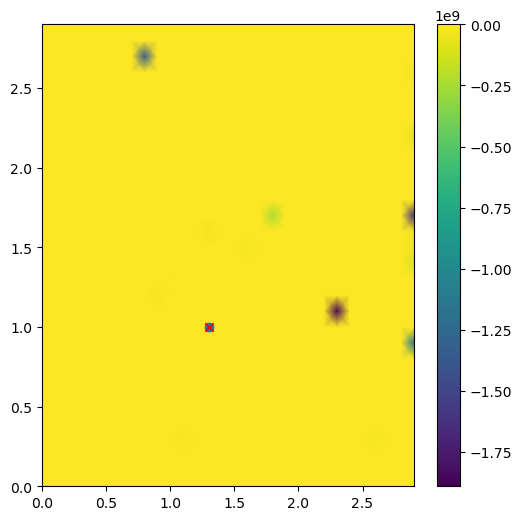

In [113]:
#alpha
xx = np.arange(0,3,0.1)
yy = np.arange(0,3,0.1)
parameter = 'alpha_gw'
injections = P.α
alpha_ll = generate_likelihood_surface(xx,yy,parameter)
plot_surface(xx,yy,alpha_ll,injections)

Maxima: 5.000000000000001e-07 7.000000000000003e-07 586621.5036995088


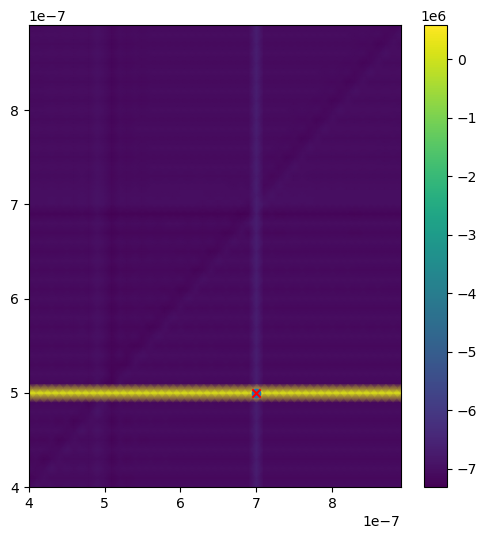

In [128]:
#omega
xx = np.arange(4e-7,9e-7,1e-8)
yy = np.arange(4e-7,9e-7,1e-8)
parameter = 'omega_gw'
injections = P.Ω
omega_ll = generate_likelihood_surface(xx,yy,parameter)
plot_surface(xx,yy,omega_ll,injections)

Maxima: 4.999999999999998e-13 4.999999999999998e-13 586621.5036995086


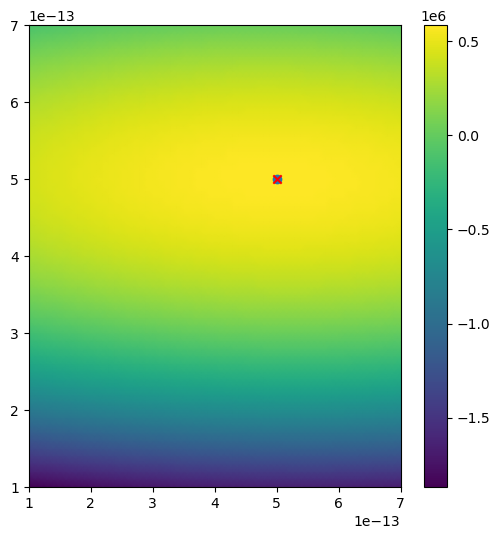

In [129]:
#h
xx = np.arange(1e-13,7e-13,1e-14)
yy = np.arange(1e-13,7e-13,1e-14)
parameter = 'h'
injections = P.h
h_ll = generate_likelihood_surface(xx,yy,parameter)
plot_surface(xx,yy,h_ll,injections)